# Long/short Trading Strategy with Support Vector Machines (SVMs)

**1. Introduction**

- The aim is to implement SVM on a trading strategy for the Luxembourg index (LUXXX) based on other indices as well as technical indicators. 
- The strategy is to take a long/short position when 0.25% change in LUXXX return is predicted. 
- The long/short position will be based on an upward or downward trending market.
- This strategy does not take into account  trading costs.

In [119]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import svm
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier

- Loading the data: The data contains weekly closing prices. 

In [120]:
data_df = pd.read_csv("data/luxxx.csv")
data_df.head(3)

,Date,LUXXX,MSCI ARGENTINA,BLP ORIENTE MEDIO,MSCI AUSTRALIA,MSCI AUSTRIA,MSCI BELGIUM,MSCI BRAZIL,MSCI CANADA,MSCI CHINA,...,MSCI NORWAY,MSCI PERU,MSCI RUSSIA,MSCI SINGAPORE,MSCI SOUTH AFRICA,MSCI SPAIN,MSCI SWEDEN,MSCI SWITZERLAND,MSCI UK,MSCI USA
0,01-Jan-16,1390.716,2376.29,3525.9150,1068.79,106.70,105.38,1036.23,1663.27,59.47,...,2373.17,811.96,404.73,1507.8101,1255.75,108.40,11136.65,1148.37,1818.40,1949.70
1,08-Jan-16,1291.267,2260.85,3280.6683,1005.56,97.66,99.35,952.01,1586.18,54.63,...,2209.38,751.09,388.05,1437.6600,1177.76,101.00,10389.93,1075.30,1722.00,1831.88
2,15-Jan-16,1257.086,2217.50,3118.2981,985.38,93.54,97.32,904.64,1541.08,51.54,...,2095.60,720.23,344.45,1372.9800,1133.72,97.34,10042.32,1056.01,1692.43,1789.56


**2. Data Preparation**

- The 'Date' column is in a string format; therefore, convert it to a datetime format

In [121]:
data_df["Date"] = pd.to_datetime(data_df["Date"])

C:\Users\Asus\AppData\Local\Temp\ipykernel_6944\939905822.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_df["Date"] = pd.to_datetime(data_df["Date"])


- Specifying the target column - the LUXXX index. The returns of LUXXX needs to be calculated since our strategy is based on the returns over the weeks. 
- The remaining indices are converted to returns instead of their prices; to scale the features into a common unit as well as to capture movements in the prices instead.

In [122]:
target_ETF = "LUXXX"

ETF_features = data_df.loc[:, ~data_df.columns.isin(["Date", target_ETF])].columns
data_df[ETF_features] = data_df[ETF_features].pct_change()

data_df[target_ETF + "_returns"] = data_df[target_ETF].pct_change()

- Next, we calculate the Target column and converts it into a categorical binary variable. 
- Denote 1 for the absolute returns of LUXXX exceeding 0.25% and 0 otherwise. In a downward or bear market, we look to short should the price decrease by more than this threshold, and we take a long position in a bear market. 
- The goal is to predict a percent change more than a threshold. 
- We shift the target column by one week to align with the predicted period available for other predictors since the ML algorithm re quires the label and feature/predictor values to be captured in the same row or observation.


In [123]:
data_df[target_ETF + "_returns" + "_shift"] = data_df[target_ETF + "_returns"].shift(-1)

# Strategy to take long position for anticipated returns of 0.5%
data_df["Target"] = np.where(
(data_df[target_ETF + "_returns_shift"].abs() > 0.025), 1, 0
)

In [124]:
# Checking target proportion
round(data_df["Target"].sum() / len(data_df), 4)

0.3452

- The proportion of 34.5% of the target class 1 does not indicate any imbalance.

- Now that we have our Target class, we can select which indices contribute to predicting the target class. We use the feature importance tool in Sklearn for a Decision Tree.
- We look at the cumulative importance for the features that make a contribution > 0. 

In [125]:
# Prepare for Train/Test split

NoNaN_df = data_df.dropna()
X = NoNaN_df[ETF_features]

X = X.iloc[:, :]
y = NoNaN_df.loc[:, "Target"]

del NoNaN_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

DTree = DecisionTreeClassifier(
    criterion="entropy",
    random_state=0,
    max_depth=8,
    min_samples_leaf=30,
    min_samples_split=20,
)

DTree.fit(X_train, y_train)

feature_importances = pd.DataFrame(
    DTree.feature_importances_,
    index=X.iloc[:, :].columns,
    columns=["importance"],
).sort_values("importance", ascending=False)

feature_importances["Cumul_Imp"] = feature_importances.cumsum().iloc[:, :]

pct_var = 1.0
feature_importances = feature_importances[(feature_importances["Cumul_Imp"] <= pct_var)]
feature_importances

,importance,Cumul_Imp
MSCI KOREA,0.436123,0.436123
MSCI DENMARK,0.219591,0.655713
MSCI FRANCE,0.196979,0.852692
MSCI NORWAY,0.147308,1.000000
MSCI ARGENTINA,0.000000,1.000000
MSCI PERU,0.000000,1.000000
MSCI MEXICO,0.000000,1.000000
MSCI NETHERLANDS,0.000000,1.000000
MSCI NEW ZEALAND,0.000000,1.000000
MSCI RUSSIA,0.000000,1.000000


- The cumulative importance shows only 4 indices that contribute, reducing features significantly and will also reduce the runtime when doing hyperparameter tuning.

              importance      Variable
MSCI KOREA      0.436123    MSCI KOREA
MSCI DENMARK    0.219591  MSCI DENMARK
MSCI FRANCE     0.196979   MSCI FRANCE
MSCI NORWAY     0.147308   MSCI NORWAY


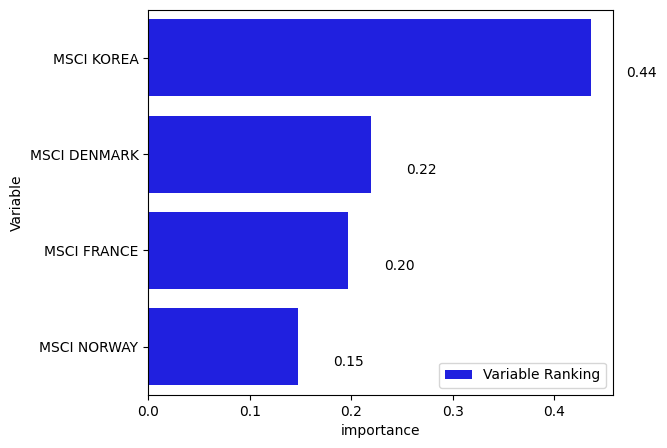

In [126]:
# Plot feature importance

cols = feature_importances.index
y_pos = np.arange(len(cols))
performance = feature_importances.importance

df2plot = pd.DataFrame(data=performance, index=feature_importances.index)
df2plot["Variable"] = feature_importances.index
df2plot = df2plot[df2plot["importance"] > 0.000]

print(df2plot)

f, ax = plt.subplots(figsize=(6,5))

sns.barplot(
    x="importance", y="Variable", data=df2plot, label="Variable Ranking", color="b"
)

for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + 0.05,
        p.get_y() + p.get_height() / 2.0 + 0.2, 
        "{:1.2f}".format(width), 
        ha="center",
    )

In [127]:
# Indices to add value in prediction
ETF_ImpFeatures = []
for i in df2plot["Variable"].values:
    ETF_ImpFeatures.append(i)

ETF_ImpFeatures

['MSCI KOREA', 'MSCI DENMARK', 'MSCI FRANCE', 'MSCI NORWAY']

**3. Technical Indicators**

- Among the first indicators are the moving average crossover of short - (SMA_5) and long-term (SMA_15). We use the ratio of (SMA_15/SMA_5) to capture the relationship as one feature and any crossovers. 
- Relies on the SVM model to capture the relationship between this feature and the target class.

In [128]:
data_df["SMA_5"] = data_df[target_ETF].rolling(5).mean()
data_df["SMA_15"] = data_df[target_ETF].rolling(15).mean()
data_df["SMA_ratio"] = data_df["SMA_15"] / data_df["SMA_5"]

- Next technical indicator is the relative strength index (RSI), which is a momentum oscillator.
- This indicator measures the magnitude of recent price changes. 
- The price is usually considered overbought when the RSI > 70% and oversold when < 30%. This is based on the price change of LUXXX before the week of prediction. 

In [129]:
# shift the price of the target by 1 unit previous in time
data_df["Diff"] = data_df[target_ETF] - data_df[target_ETF].shift(1)
data_df["Up"] = data_df["Diff"]
data_df.loc[(data_df["Up"] < 0), "Up"] = 0

data_df["Down"] = data_df["Diff"]
data_df.loc[(data_df["Down"] > 0), "Down"] = 0
data_df["Down"] = abs(data_df["Down"])

data_df["avg_5up"] = data_df["Up"].rolling(5).mean()
data_df["avg_5down"] = data_df["Down"].rolling(5).mean()

data_df["avg_15up"] = data_df["Up"].rolling(15).mean()
data_df["avg_15down"] = data_df["Down"].rolling(15).mean()

data_df["RS_5"] = data_df["avg_5up"] / data_df["avg_5down"]
data_df["RS_15"] = data_df["avg_15up"] / data_df["avg_15down"]

data_df["RSI_5"] = 100 - (100 / (1 + data_df["RS_5"]))
data_df["RSI_15"] = 100 - (100 / (1 + data_df["RS_15"]))

data_df["RSI_ratio"] = data_df["RSI_5"] / data_df["RSI_15"]

# Can drop RS Calc columns columns
data_df.drop(
    ["Diff", "Up", "Down", "avg_5up", "avg_5down", "avg_15up", "avg_15down"],
    axis=1,
    inplace=True,
)

- Rate of change is teh percentage change in price over 15-week period. It's a long-term rate of change and is also a momentum indicator. Also used to spot overbought and oversold instances. 

In [130]:
data_df["RC"] = data_df[target_ETF].pct_change(periods=15)

- Next is combining all features, that is the indices' price change as well as the technical indicators.

In [131]:
# all_feats
ETF_ImpFeatures.append("SMA_ratio")
ETF_ImpFeatures.append("RSI_ratio")
ETF_ImpFeatures.append("RC")

**4. Model Training**

In [132]:
# Train/Test split
# Train/Test split. No NaNs in the data.
NoNaN_df = data_df.dropna()
X = NoNaN_df[ETF_ImpFeatures]

X = X.iloc[:, :]  # .values
y = NoNaN_df.loc[:, "Target"]  # .values

del NoNaN_df

# from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

- Using GridsearchCv to determine the best kernel and slack. 

In [133]:
# defining parameter range
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100, 1000],
    #               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    "kernel": ["rbf", "linear", "poly"],
}

grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=3, cv=5)

# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END ................C=0.01, kernel=rbf;, score=0.711 total time=   0.0s
[CV 2/5] END ................C=0.01, kernel=rbf;, score=0.711 total time=   0.0s
[CV 3/5] END ................C=0.01, kernel=rbf;, score=0.684 total time=   0.0s
[CV 4/5] END ................C=0.01, kernel=rbf;, score=0.703 total time=   0.0s
[CV 5/5] END ................C=0.01, kernel=rbf;, score=0.703 total time=   0.0s
[CV 1/5] END .............C=0.01, kernel=linear;, score=0.711 total time=   0.0s
[CV 2/5] END .............C=0.01, kernel=linear;, score=0.711 total time=   0.0s
[CV 3/5] END .............C=0.01, kernel=linear;, score=0.684 total time=   0.0s
[CV 4/5] END .............C=0.01, kernel=linear;, score=0.703 total time=   0.0s
[CV 5/5] END .............C=0.01, kernel=linear;, score=0.703 total time=   0.0s
[CV 1/5] END ...............C=0.01, kernel=poly;, score=0.711 total time=   0.0s
[CV 2/5] END ...............C=0.01, kernel=poly;

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'kernel': ['rbf', 'linear', 'poly']},
             verbose=3)

- Best hyperparameters: Polynomial kernel with a slack variable value of 10.

In [134]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 100, 'kernel': 'rbf'}
SVC(C=100)


- Training the model for the specified hyperparameters and compare wiwth an untuned decision tree classifier:

In [135]:
# Train with Tuned SVM
# Create a svm Classifier
clf_tuned = svm.SVC(
    random_state=0,
    C=grid.best_params_["C"],
    kernel=grid.best_params_["kernel"],
    probability=True,
)

clf_tuned.fit(X_train, y_train)


# Fitting Decision Tree Classification to the Training set as well

clf_tree = DecisionTreeClassifier(
    criterion="entropy",
    random_state=0,
    max_depth=8,
    min_samples_leaf=30,  # DM
    min_samples_split=20,
    #                               , class_weight=classweight
)  # DM
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=30,
                       min_samples_split=20, random_state=0)

**5. Performance**

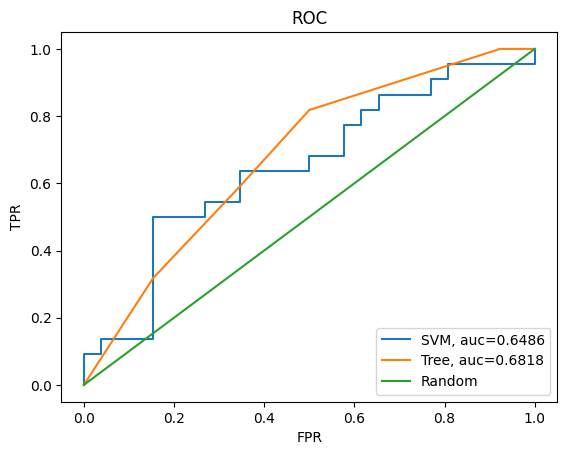

In [136]:
# Performance

# predicted probabilities generated by sklearn classifier
y_pred_proba = clf_tuned.predict_proba(X_test)
y_pred_probatree = clf_tree.predict_proba(X_test)

# SVM ROC dependencies
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
# TREE ROC dependencies
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_probatree[:, 1])

auc = round(roc_auc_score(y_test, y_pred_proba[:, 1]), 4)
auc_tree = round(roc_auc_score(y_test, y_pred_probatree[:, 1]), 4)

# SVM Model
plt.plot(fpr, tpr, label="SVM, auc=" + str(auc))
# Tree model
plt.plot(fpr_tree, tpr_tree, label="Tree, auc=" + str(auc_tree))
# Random guess model
plt.plot(fpr, fpr, "-", label="Random")
plt.title("ROC")
plt.ylabel("TPR")
plt.xlabel("FPR")

plt.legend(loc=4)
plt.show()